In [243]:
import tensorflow as tf

In [244]:
import pandas as pd
full_df = pd.read_csv("bird_songs_metadata.csv")
full_df

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5417,11713,Cardinalis,cardinalis,NaN,Northern Cardinal,Chris Parrish,United States,"Sewanee, Franklin County, Tennessee",35.2176,-85.9220,580,song,//www.xeno-canto.org/11713,//creativecommons.org/licenses/by-nc-nd/2.5/,06:21,2007-03-31,NaN,11713-8.wav
5418,11713,Cardinalis,cardinalis,NaN,Northern Cardinal,Chris Parrish,United States,"Sewanee, Franklin County, Tennessee",35.2176,-85.9220,580,song,//www.xeno-canto.org/11713,//creativecommons.org/licenses/by-nc-nd/2.5/,06:21,2007-03-31,NaN,11713-10.wav
5419,11713,Cardinalis,cardinalis,NaN,Northern Cardinal,Chris Parrish,United States,"Sewanee, Franklin County, Tennessee",35.2176,-85.9220,580,song,//www.xeno-canto.org/11713,//creativecommons.org/licenses/by-nc-nd/2.5/,06:21,2007-03-31,NaN,11713-14.wav
5420,11713,Cardinalis,cardinalis,NaN,Northern Cardinal,Chris Parrish,United States,"Sewanee, Franklin County, Tennessee",35.2176,-85.9220,580,song,//www.xeno-canto.org/11713,//creativecommons.org/licenses/by-nc-nd/2.5/,06:21,2007-03-31,NaN,11713-15.wav


In [245]:
TRAIN_AUDIO_BATCHES_SIZE = 20
TEST_AUDIO_BATCHES_SIZE = 10
AUDIO_BATCHES_SIZE = TRAIN_AUDIO_BATCHES_SIZE + TEST_AUDIO_BATCHES_SIZE

df = full_df[['species', 'filename']] \
        .groupby(['species'], group_keys=True) \
        .head(AUDIO_BATCHES_SIZE) \
        .apply(lambda x: x)
with open('log.txt', 'w') as f:
        f.writelines(df.filename.to_numpy())



In [246]:
files_batches = df.filename.to_numpy().reshape(len(df) // AUDIO_BATCHES_SIZE, AUDIO_BATCHES_SIZE)
num_classes = len(files_batches)
labels = df.species.to_numpy().reshape(len(df) // AUDIO_BATCHES_SIZE, AUDIO_BATCHES_SIZE)[:, 0]
labels

array(['bewickii', 'polyglottos', 'migratorius', 'melodia', 'cardinalis'],
      dtype=object)

C:\Users\nikolya\AppData\Local\Temp\ipykernel_14268\591800382.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


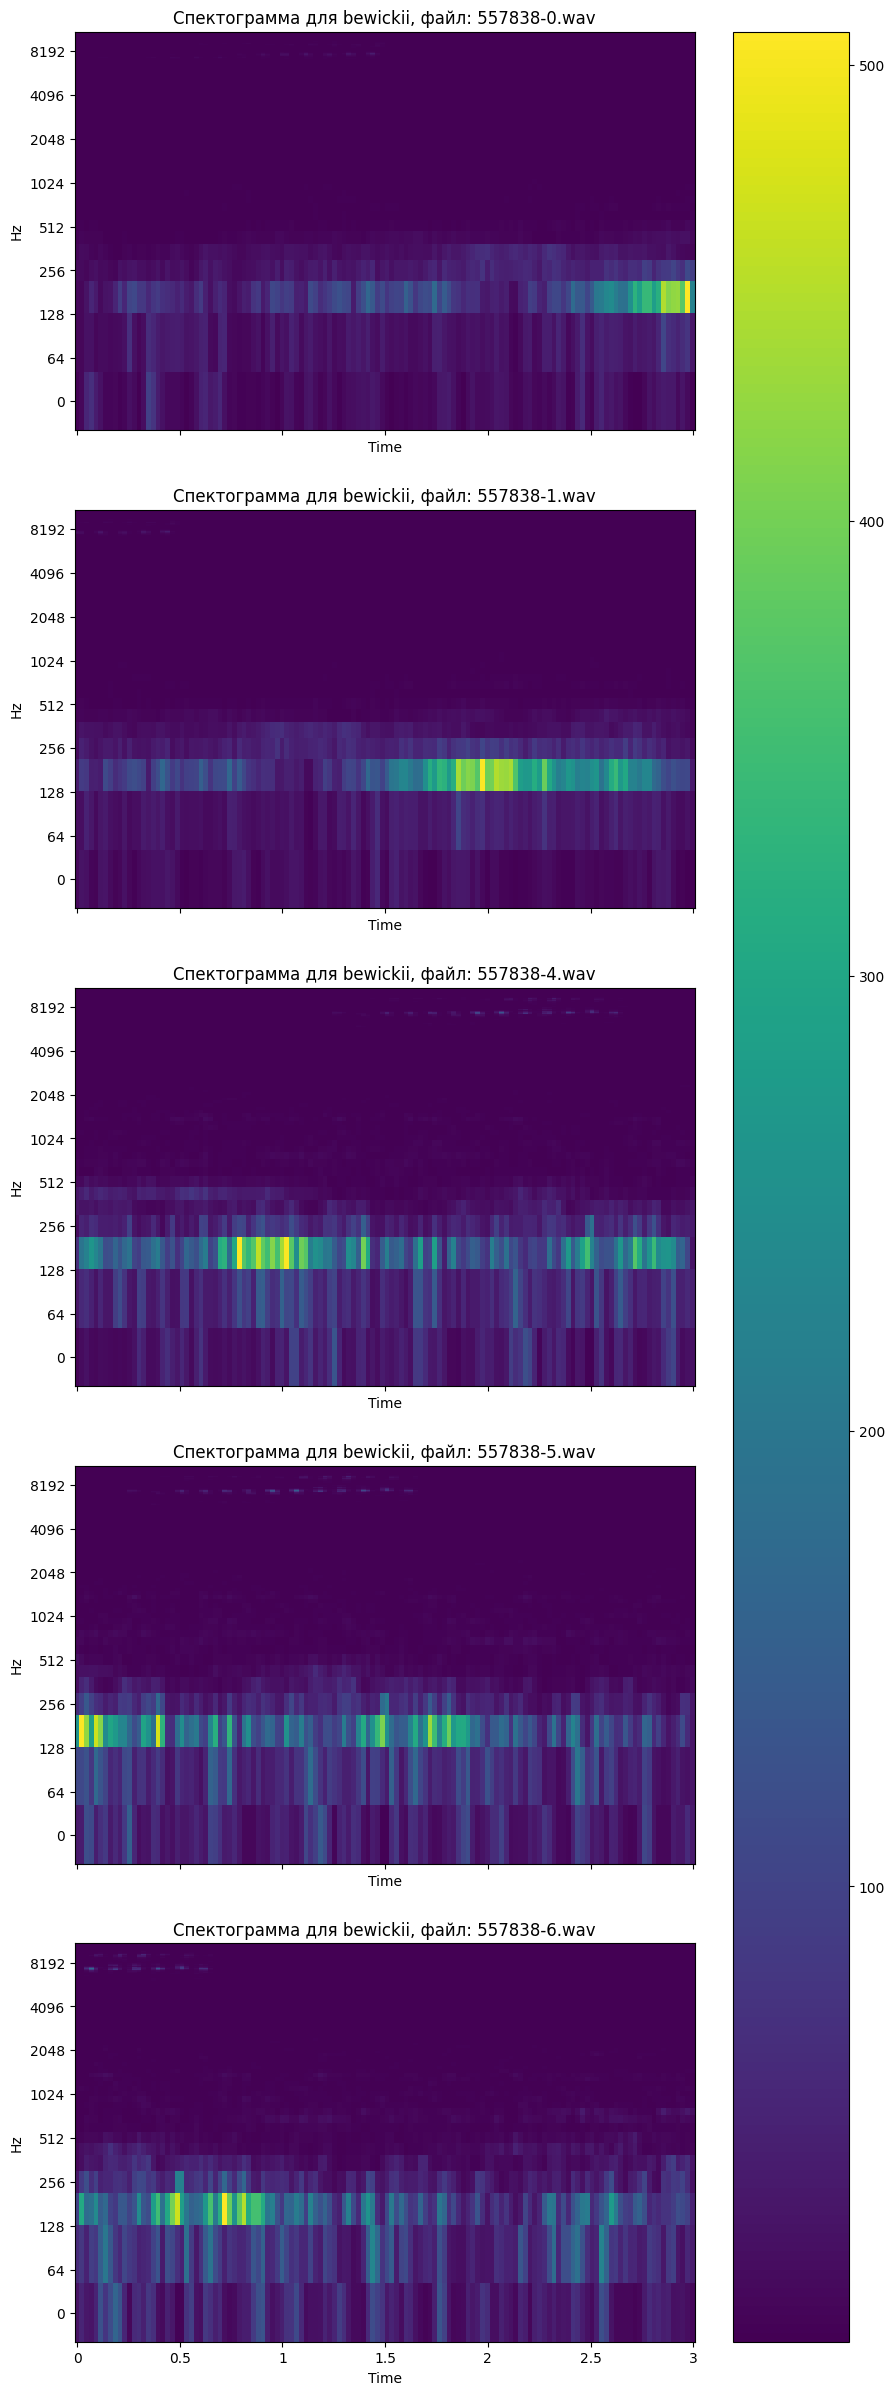

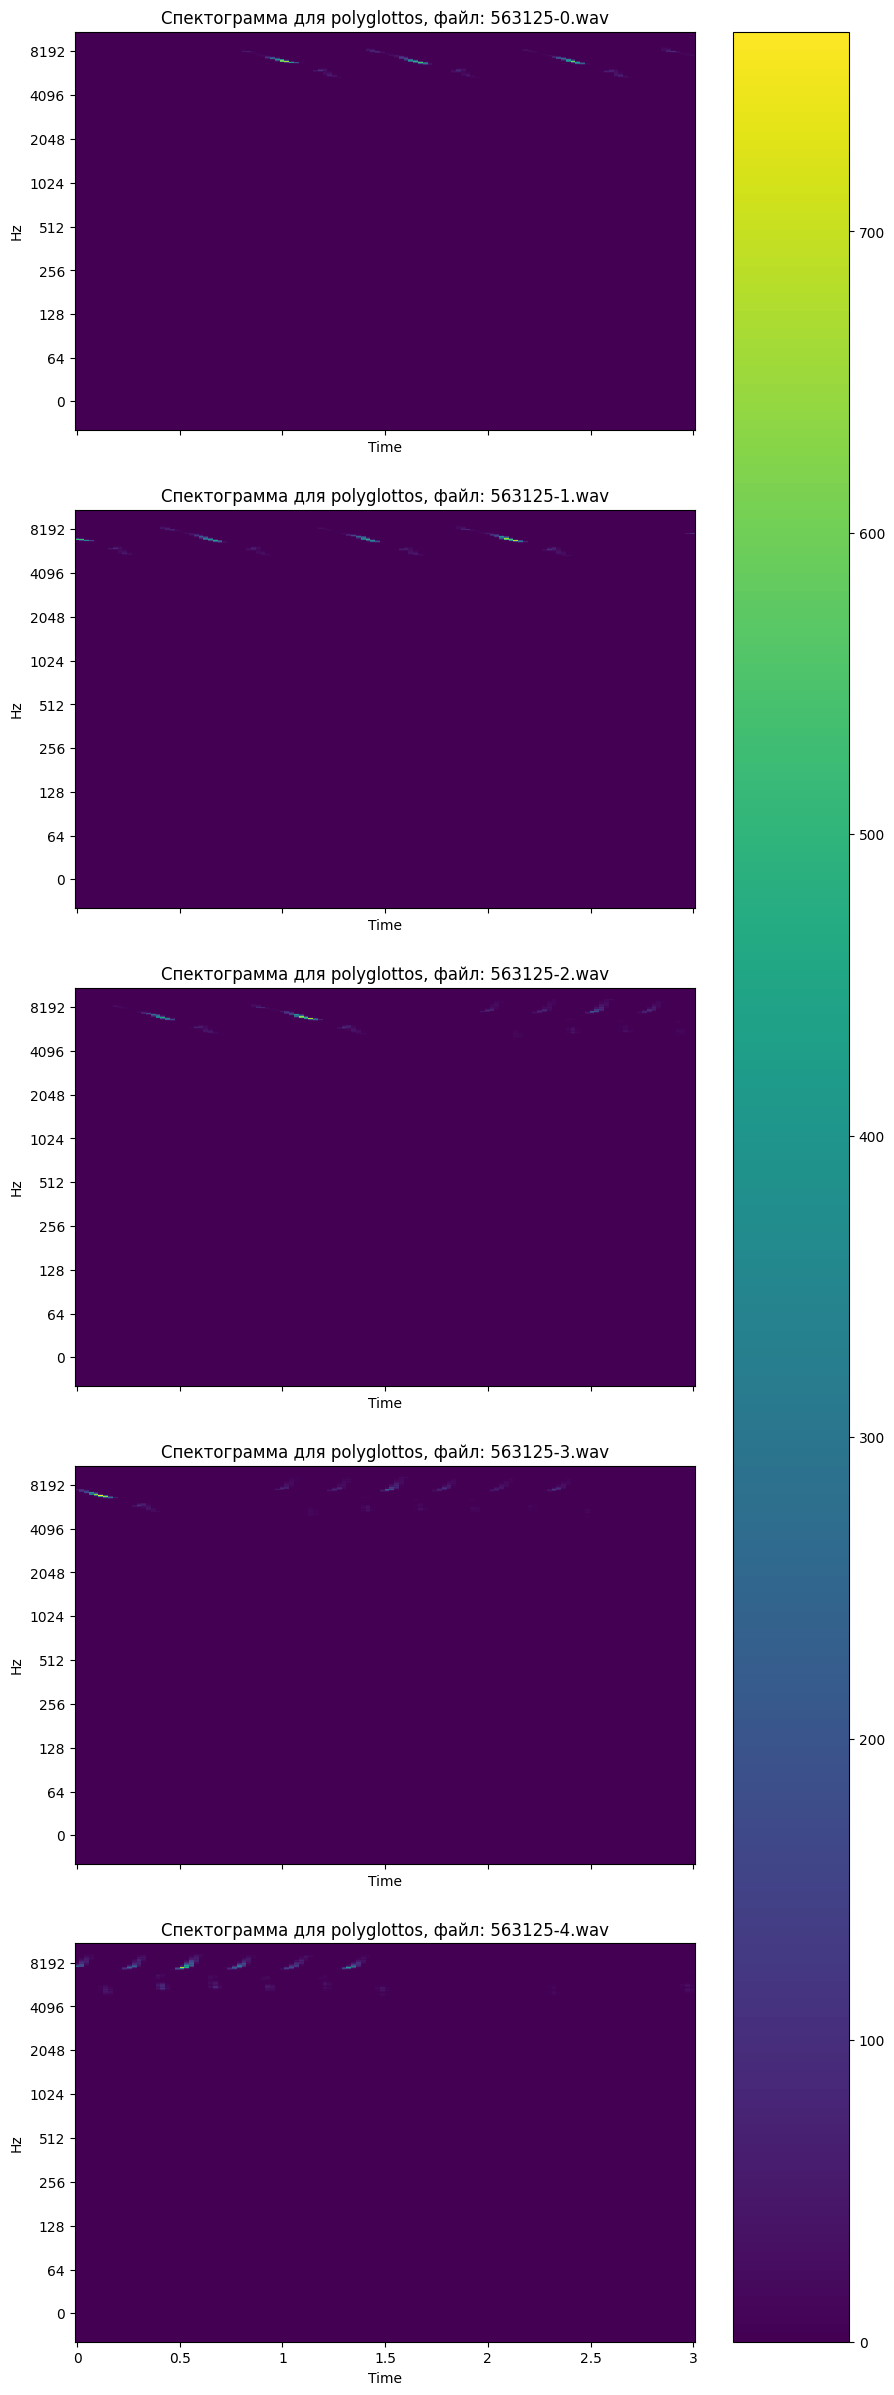

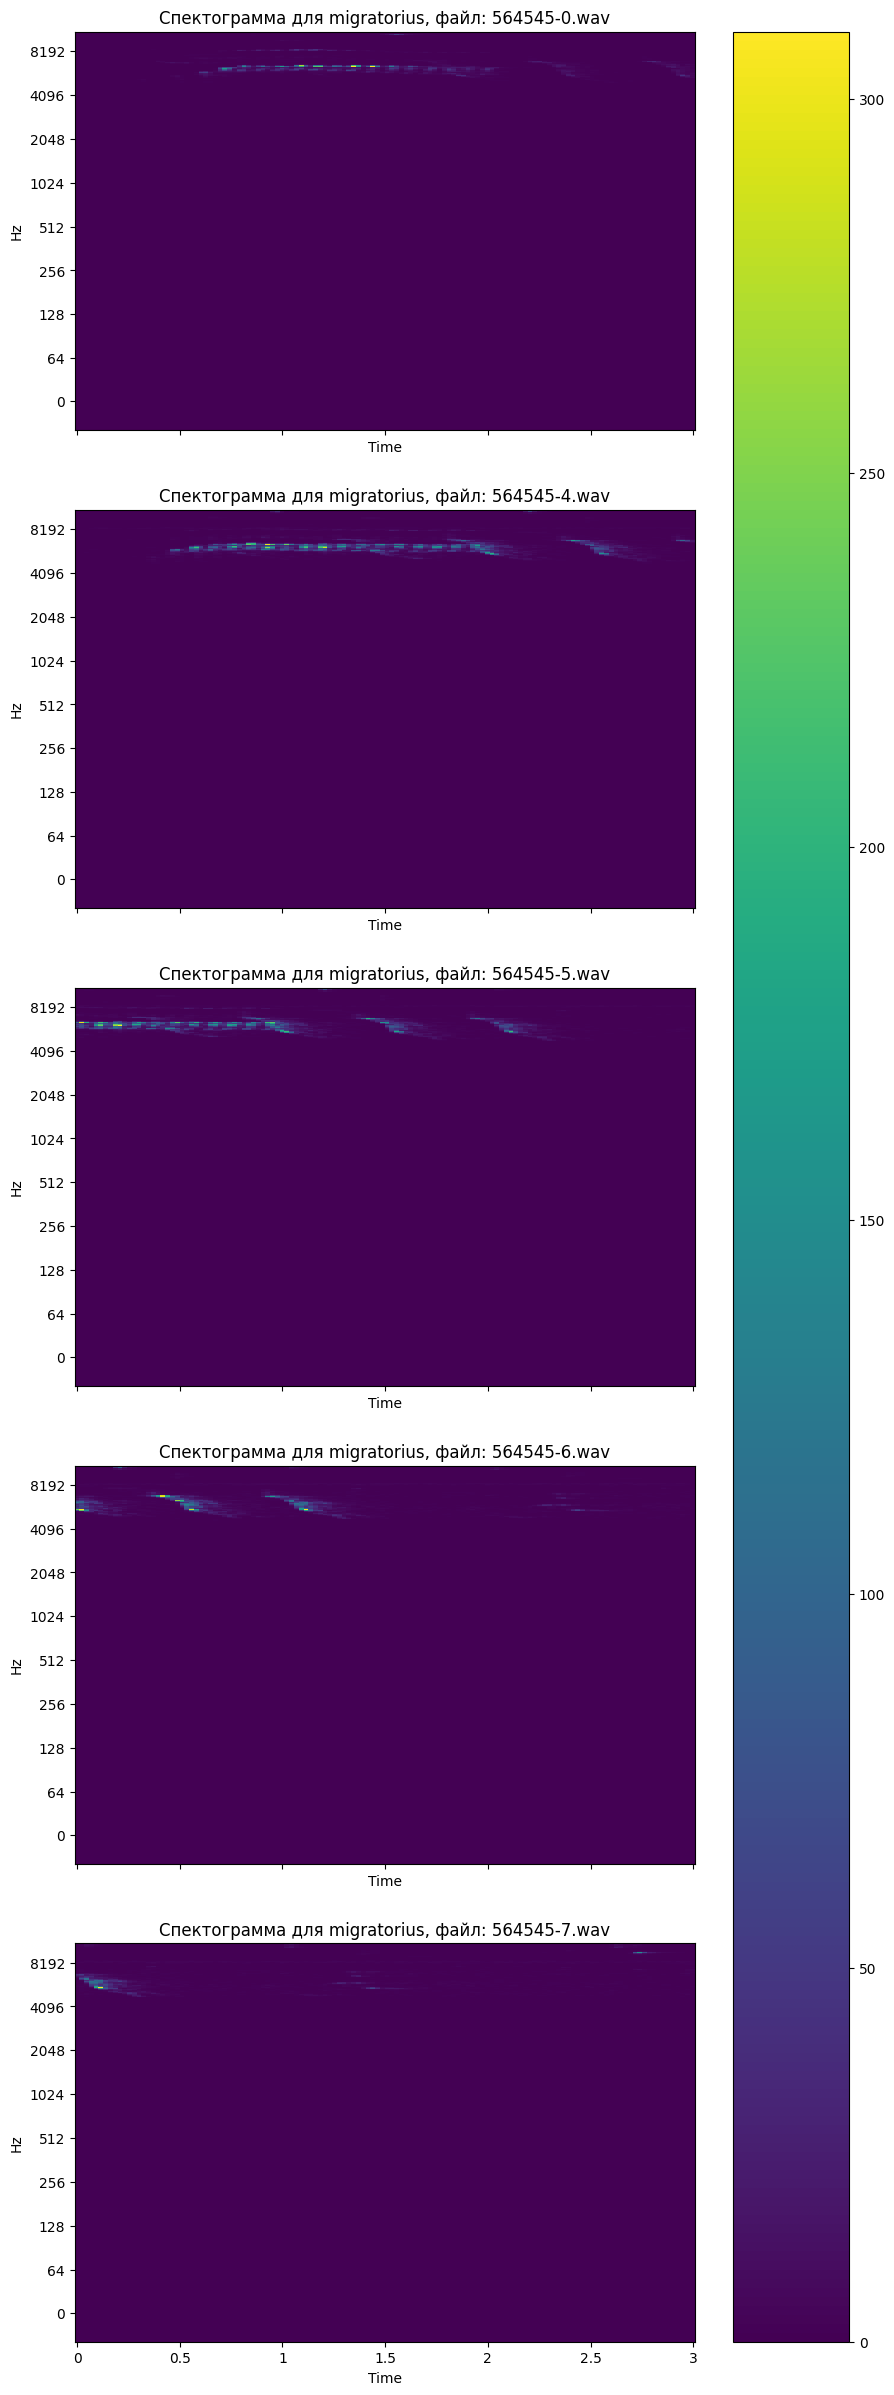

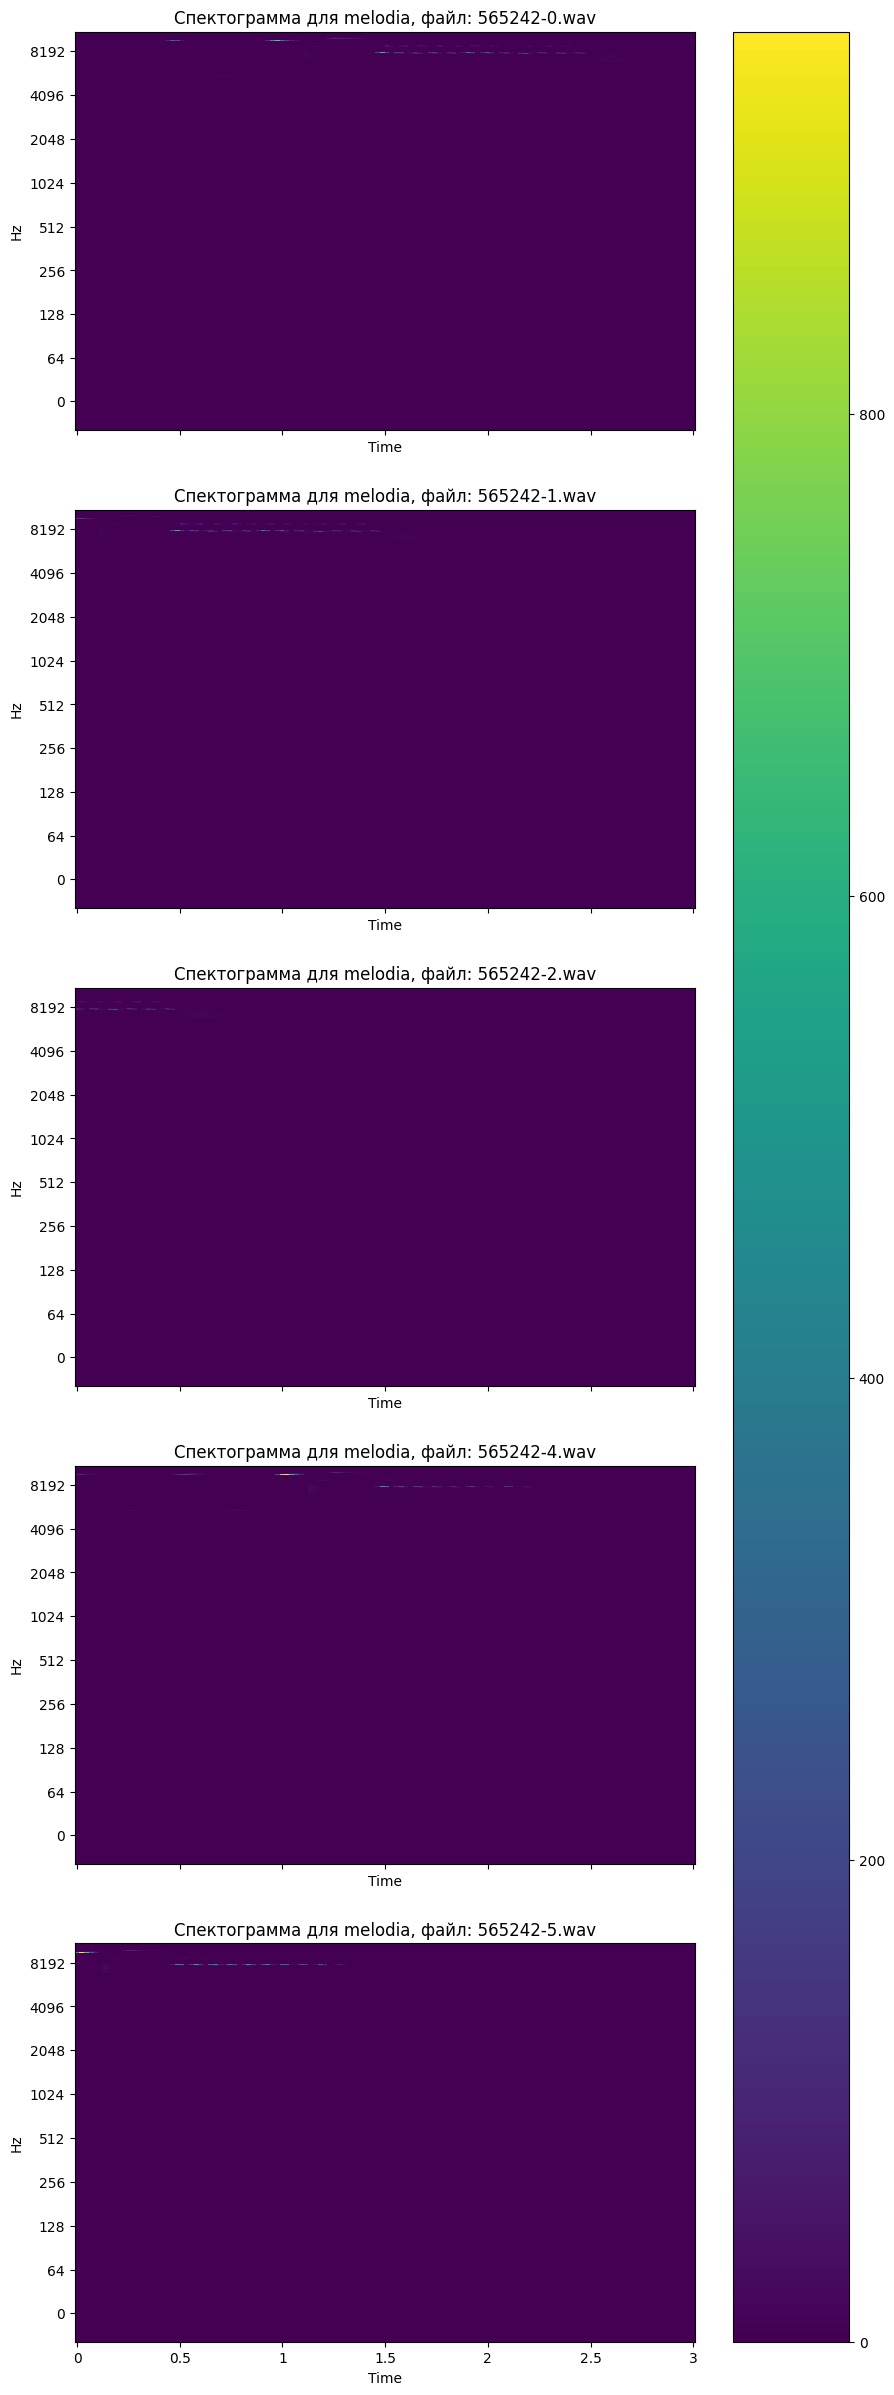

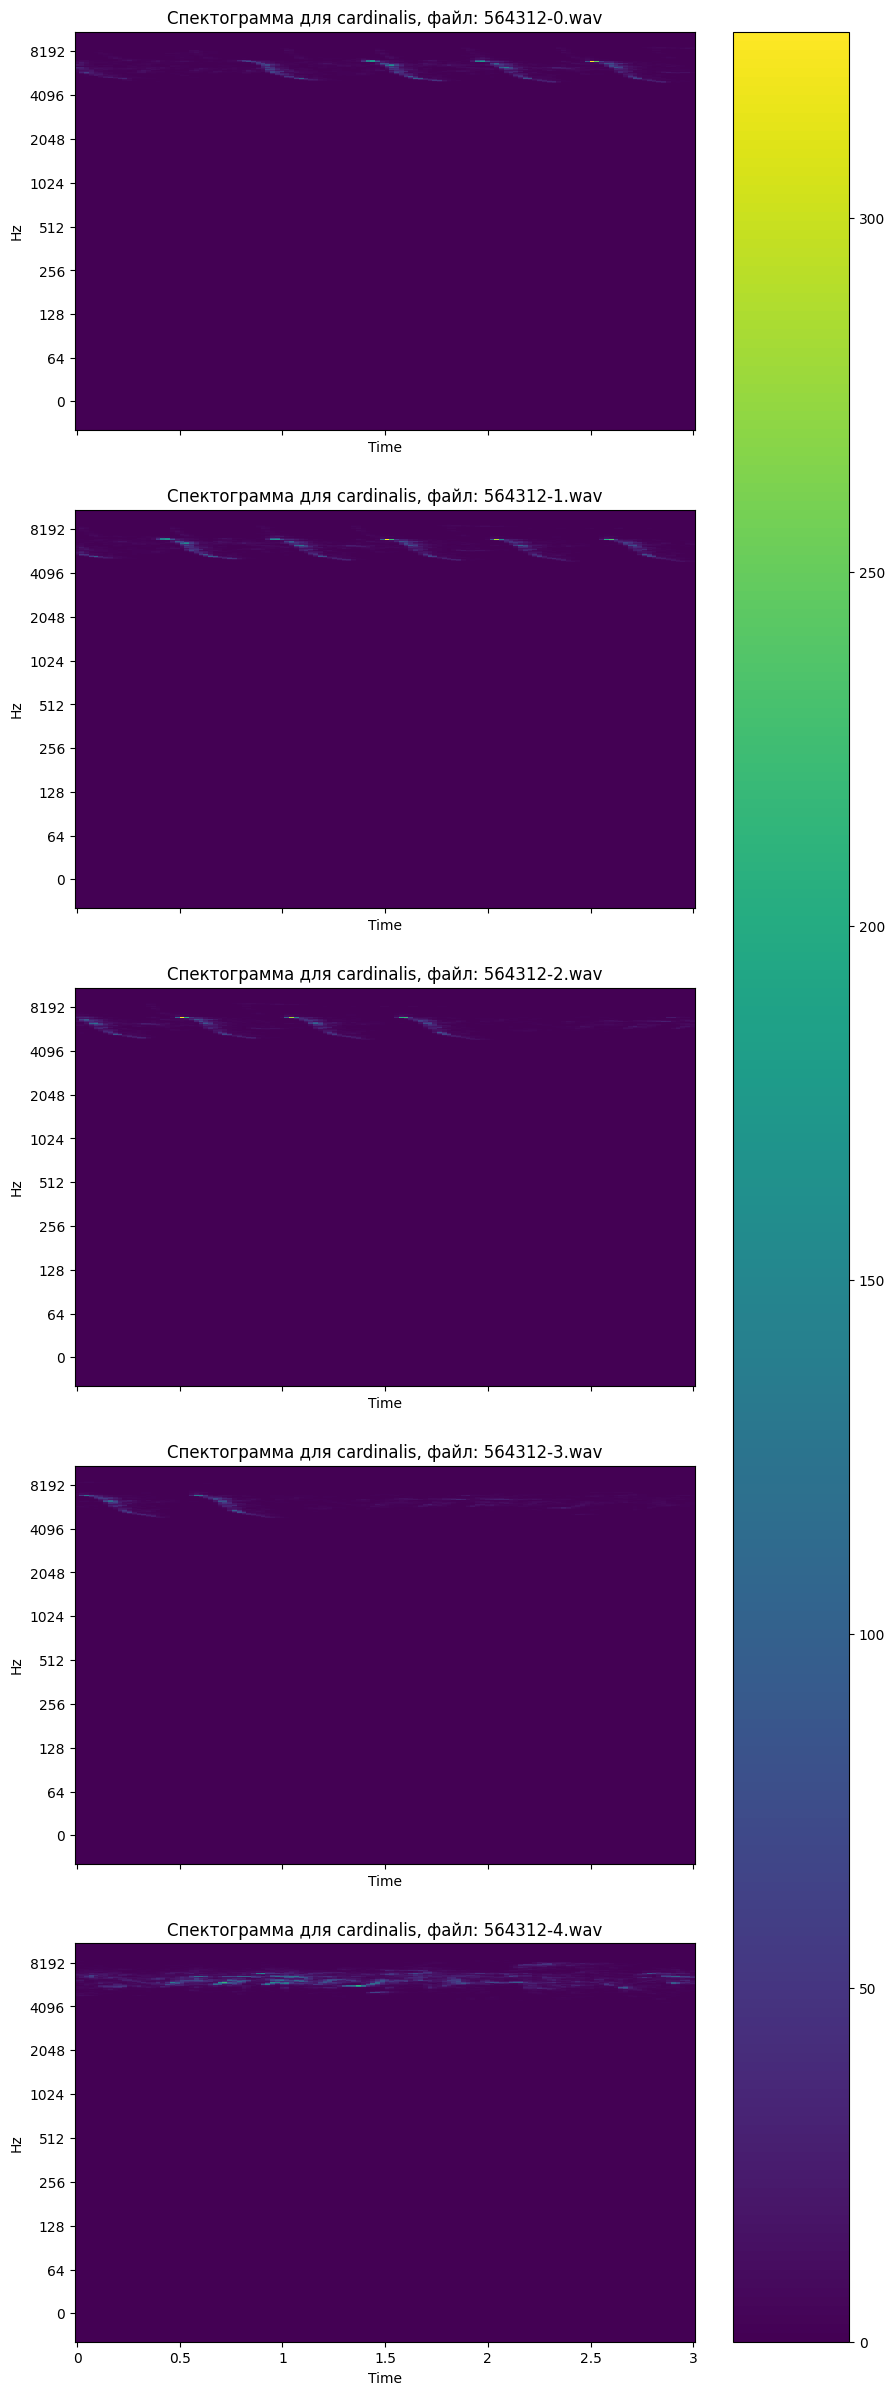

In [247]:
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np
    

def train_test_splt(array, num_classes, batch_size, train_size):
    train = []
    test = []    
    for i in range(num_classes):
        train.extend(array[i * batch_size: i * batch_size + train_size])
        test.extend(array[i * batch_size + train_size: (i + 1) * batch_size])

    return np.array(train), np.array(test)
    
directory_basename = 'wavfiles' 
total_distance = 0
features = []
classes = []
for label_idx, files in enumerate(files_batches):
    file_paths = list(map(lambda fileName: os.path.join(directory_basename, fileName), files)) 
    fig, ax = plt.subplots(nrows=5, ncols=1, sharex=True, figsize=(10, 30))
    for idx, file_path in enumerate(file_paths[:AUDIO_BATCHES_SIZE]):
        with open(file_path) as f:
            y, sr = librosa.load(file_path)
            spec = np.expand_dims(np.array(librosa.feature.melspectrogram(y=y, sr=sr)), axis=0)
            features.append(spec)
            classes.append(labels[label_idx])
            if (idx < 5):
                img = librosa.display.specshow(spec[0], y_axis='log', x_axis='time', sr=sr, cmap='viridis', ax=ax[idx])
                ax[idx].set(title=f'Спектограмма для {labels[label_idx]}, файл: {os.path.basename(file_path)}')   
        
    fig.colorbar(img, ax=ax)
    fig.show()

train_features, test_features = train_test_splt(features, num_classes, AUDIO_BATCHES_SIZE, TRAIN_AUDIO_BATCHES_SIZE)


In [248]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
classes = label_encoder.fit_transform(classes)
train_classes, test_classes = train_test_splt(classes, num_classes, AUDIO_BATCHES_SIZE, TRAIN_AUDIO_BATCHES_SIZE)
train_classes.shape

(100,)

In [249]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=train_features.shape[1:]),

    tf.keras.layers.Resizing(32, 32),
    tf.keras.layers.Conv2D(32, 4, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 5, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes),
])

In [250]:
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

Epoch 1/15
4/4 [==============================] - 1s 99ms/step - loss: 2.8290 - accuracy: 0.3400
Epoch 2/15
4/4 [==============================] - 0s 99ms/step - loss: 1.0048 - accuracy: 0.6300
Epoch 3/15
4/4 [==============================] - 0s 99ms/step - loss: 0.6294 - accuracy: 0.8000
Epoch 4/15
4/4 [==============================] - 0s 108ms/step - loss: 0.5254 - accuracy: 0.8300
Epoch 5/15
4/4 [==============================] - 0s 100ms/step - loss: 0.2225 - accuracy: 0.9100
Epoch 6/15
4/4 [==============================] - 0s 95ms/step - loss: 0.1685 - accuracy: 0.9500
Epoch 7/15
4/4 [==============================] - 0s 102ms/step - loss: 0.1694 - accuracy: 0.9300
Epoch 8/15
4/4 [==============================] - 0s 97ms/step - loss: 0.0704 - accuracy: 0.9700
Epoch 9/15
4/4 [==============================] - 0s 121ms/step - loss: 0.0859 - accuracy: 0.9800
Epoch 10/15
4/4 [==============================] - 1s 127ms/step - loss: 0.2252 - accuracy: 0.9500
Epoch 11/15
4/4 [=======

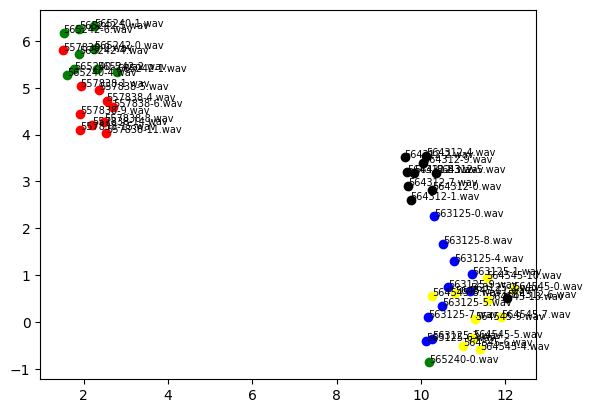

In [251]:
from umap import UMAP

EPOCHS = 15
history = model.fit(
    train_features,
    train_classes,
    epochs=EPOCHS,
)

min_distanse = 1e9
predictions = [ model.predict(np.array([feature]))[0] for feature in test_features]
for i, other_prediction in enumerate(predictions):
      for j in range(i + 1, len(predictions)):
            current_distance = np.linalg.norm(predictions[j] - other_prediction) 
            if (current_distance < min_distanse):
                  min_distanse = current_distance
                  optimal_embedding_i = i
                  optimal_embedding_j = j 

print(optimal_embedding_i, optimal_embedding_j)
embeddings = UMAP().fit_transform(predictions)
print(embeddings)
species_to_colors = {
    0: "red",
    1: "blue",
    2: "yellow",
    3: "green",
    4: "black"
}

for i in range(0, len(embeddings), TEST_AUDIO_BATCHES_SIZE):
    specious_embeddings = list(zip(*embeddings[i: i + TEST_AUDIO_BATCHES_SIZE]))   
    plt.scatter(specious_embeddings[0], specious_embeddings[1], 
                c=species_to_colors[i // TEST_AUDIO_BATCHES_SIZE ])

for j, embs in enumerate(embeddings):
        plt.text(embs[0], embs[1], 
                 files_batches[j // TEST_AUDIO_BATCHES_SIZE][j % TEST_AUDIO_BATCHES_SIZE], fontsize=7)

plt.show()


### Похожие эмбеддинги: 


In [252]:
from IPython.display import Audio
filename_j = files_batches[optimal_embedding_j // TEST_AUDIO_BATCHES_SIZE][optimal_embedding_j % TEST_AUDIO_BATCHES_SIZE]
print(filename_j)
Audio(f"wavfiles/{filename_j}")

565242-4.wav


In [253]:
filename_i = files_batches[optimal_embedding_i // TEST_AUDIO_BATCHES_SIZE][optimal_embedding_i % TEST_AUDIO_BATCHES_SIZE]
print(filename_i)
Audio(f"wavfiles/{filename_i}")

565242-0.wav


In [254]:
print(f"Accuracy: {(np.array(predictions).argmax(axis=1) == test_classes).sum() / len(test_classes)}")

Accuracy: 0.64
